In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from scipy.stats import shapiro, mannwhitneyu, skew, kurtosis

### 1. MySQL로 추출한 데이터 csv 파일 불러오기
- 네드베드를 LW와 LCM으로 구분한 파일
- 각 포지션에서 50판씩 진행
    - 단, 몰수승, 몰수패 경기로 인한 경기수 차이 존재
    - LW: 49판 / LCM: 47판

In [2]:
# 네드베드를 lw로 기용했을 때의 경기 정보 테이블
lw_cte = pd.read_csv('C:\\Users\\이진호\\Desktop\\Programming\\프로젝트\\MyProject2\\AB_Test\\lw_cte.csv', encoding='euc-kr')
lw_cte = lw_cte.drop(columns=['matchType', 'ouid', 'nickname'])
print(len(lw_cte))
lw_cte.head(3)

49


,matchId,matchDate,matchResult,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,681a44dd81eceee465f4ec97,2025-05-06T17:30:48,패,"{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 265235805, 'spPosition': 15, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 802247703, 'spPosition': 28, 'spGrade...","{'spId': 801007763, 'spPosition': 28, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 265232488, 'spPosition': 28, 'spGrade...","{'spId': 251001075, 'spPosition': 23, 'spGrade...","{'spId': 251006235, 'spPosition': 27, 'spGrade...","{'spId': 508193082, 'spPosition': 28, 'spGrade..."
1,681a421c5edf0476b5f2e547,2025-05-06T17:19:25,무,"{'spId': 508193082, 'spPosition': 28, 'spGrade...","{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 265235805, 'spPosition': 15, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 251001075, 'spPosition': 23, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 251006235, 'spPosition': 27, 'spGrade...","{'spId': 801007763, 'spPosition': 28, 'spGrade...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 265232488, 'spPosition': 28, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 802247703, 'spPosition': 28, 'spGrade..."
2,681a3f4431bdaf02863336b3,2025-05-06T17:07:43,무,"{'spId': 251001075, 'spPosition': 23, 'spGrade...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 251006235, 'spPosition': 27, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 802247703, 'spPosition': 28, 'spGrade...","{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 508193082, 'spPosition': 28, 'spGrade...","{'spId': 265232488, 'spPosition': 28, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 801007763, 'spPosition': 28, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 265235805, 'spPosition': 15, 'spGrade..."


In [3]:
# 네드베드를 lcm으로 기용했을 때의 경기 정보 테이블
lcm_cte = pd.read_csv('C:\\Users\\이진호\\Desktop\\Programming\\프로젝트\\MyProject2\\AB_Test\\lcm_cte.csv', encoding='euc-kr')
lcm_cte = lcm_cte.drop(columns=['matchType', 'ouid', 'nickname'])
print(len(lcm_cte))
lcm_cte.head(3)

47


,matchId,matchDate,matchResult,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,6817a243d17d0dae25a87579,2025-05-04T17:32:39,패,"{'spId': 801007763, 'spPosition': 28, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 802247703, 'spPosition': 28, 'spGrade...","{'spId': 265235805, 'spPosition': 27, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 251006235, 'spPosition': 15, 'spGrade...","{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 508193082, 'spPosition': 28, 'spGrade...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 265232488, 'spPosition': 28, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 251001075, 'spPosition': 23, 'spGrade..."
1,68179f92c61d8c7ac22485fa,2025-05-04T17:21:20,승,"{'spId': 508193082, 'spPosition': 28, 'spGrade...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 251006235, 'spPosition': 15, 'spGrade...","{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 802247703, 'spPosition': 28, 'spGrade...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 801007763, 'spPosition': 28, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 251001075, 'spPosition': 23, 'spGrade...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 265235805, 'spPosition': 27, 'spGrade...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 265232488, 'spPosition': 28, 'spGrade..."
2,68179d07da947d3c2651b680,2025-05-04T17:10:21,승,"{'spId': 110167198, 'spPosition': 28, 'spGrade...","{'spId': 256191043, 'spPosition': 7, 'spGrade'...","{'spId': 814206058, 'spPosition': 4, 'spGrade'...","{'spId': 802247703, 'spPosition': 28, 'spGrade...","{'spId': 265202884, 'spPosition': 3, 'spGrade'...","{'spId': 508193082, 'spPosition': 28, 'spGrade...","{'spId': 810201153, 'spPosition': 25, 'spGrade...","{'spId': 291199304, 'spPosition': 6, 'spGrade'...","{'spId': 270233500, 'spPosition': 28, 'spGrade...","{'spId': 251186153, 'spPosition': 28, 'spGrade...","{'spId': 268051539, 'spPosition': 0, 'spGrade'...","{'spId': 251001075, 'spPosition': 23, 'spGrade...","{'spId': 825001397, 'spPosition': 13, 'spGrade...","{'spId': 251006235, 'spPosition': 15, 'spGrade...","{'spId': 265232488, 'spPosition': 28, 'spGrade...","{'spId': 265235805, 'spPosition': 27, 'spGrade...","{'spId': 829005099, 'spPosition': 10, 'spGrade...","{'spId': 801007763, 'spPosition': 28, 'spGrade..."


### 2. 데이터 가공 작업
- 특정 선수(네드베드)의 정보만 추출
    - 문자열을 딕셔너리로 변환
    - 새로운 열로 확장하여 데이터프레임에 결합
- LW와 LCM 데이터프레임 결합
- 컬럼 가공

In [4]:
# 특정 선수 정보 추출 함수
def extract(cte, position):
    df1 = cte.iloc[:,:3]
    df2 = cte.iloc[:,3:]

    # 딕셔너리로 변환해서 spPosition = position인 것만 추출
    result_list = []
    for row in df2.values.flatten():
        d = ast.literal_eval(row)
        if d.get('spPosition') == position:
            result_list.append(d['status'])

    # 딕셔너리 리스트 → DataFrame
    filtered_df = pd.DataFrame(result_list)

    return pd.concat([df1, filtered_df], axis=1)

In [5]:
lw_df = extract(lw_cte, 27) # lw의 spPosition: 27
lw_df['position'] = 'LW'
print(len(lw_df))
lw_df.head(3)

49


,matchId,matchDate,matchResult,shoot,effectiveShoot,assist,goal,dribble,intercept,defending,passTry,passSuccess,dribbleTry,dribbleSuccess,ballPossesionTry,ballPossesionSuccess,aerialTry,aerialSuccess,blockTry,block,tackleTry,tackle,yellowCards,redCards,spRating,position
0,681a44dd81eceee465f4ec97,2025-05-06T17:30:48,패,0,0,0,0,97,0,1,6,4,5,5,4,1,2,0,0,0,1,0,0,0,6.0,LW
1,681a421c5edf0476b5f2e547,2025-05-06T17:19:25,무,0,0,0,0,122,1,0,12,11,6,6,3,2,3,0,1,0,1,1,0,0,6.6,LW
2,681a3f4431bdaf02863336b3,2025-05-06T17:07:43,무,1,1,1,1,176,1,0,6,5,4,4,4,2,2,0,0,0,1,1,0,0,8.0,LW


In [6]:
lcm_df = extract(lcm_cte, 15)   # lcm의 spPosition: 15
lcm_df['position'] = 'LCM'
print(len(lcm_df))
lcm_df.head(3)

47


,matchId,matchDate,matchResult,shoot,effectiveShoot,assist,goal,dribble,intercept,defending,passTry,passSuccess,dribbleTry,dribbleSuccess,ballPossesionTry,ballPossesionSuccess,aerialTry,aerialSuccess,blockTry,block,tackleTry,tackle,yellowCards,redCards,spRating,position
0,6817a243d17d0dae25a87579,2025-05-04T17:32:39,패,1,1,0,0,86,1,0,5,3,3,3,3,2,2,0,0,0,1,1,0,0,6.0,LCM
1,68179f92c61d8c7ac22485fa,2025-05-04T17:21:20,승,0,0,0,0,147,1,0,14,12,11,11,3,1,0,0,0,0,3,1,0,0,6.7,LCM
2,68179d07da947d3c2651b680,2025-05-04T17:10:21,승,1,1,0,0,159,0,0,10,10,9,8,3,2,1,0,0,0,1,0,0,0,6.4,LCM


In [7]:
df_merged = pd.concat([lw_df, lcm_df])
df_merged = df_merged.sort_values(by='matchDate').reset_index(drop=True)
df_merged.head(3)

,matchId,matchDate,matchResult,shoot,effectiveShoot,assist,goal,dribble,intercept,defending,passTry,passSuccess,dribbleTry,dribbleSuccess,ballPossesionTry,ballPossesionSuccess,aerialTry,aerialSuccess,blockTry,block,tackleTry,tackle,yellowCards,redCards,spRating,position
0,6813a3b39f27408629416288,2025-05-01T16:49:07,패,0,0,0,0,153,0,0,6,4,3,3,4,2,0,0,0,0,0,0,0,0,6.1,LCM
1,6813a7902973521e734c5324,2025-05-01T17:05:30,패,0,0,0,0,131,1,1,10,10,6,6,3,2,5,0,1,0,2,1,0,0,6.5,LCM
2,6813aa1eee91fff301f0f48f,2025-05-01T17:17:01,무,2,2,0,0,116,1,0,16,13,7,7,5,2,3,0,0,0,1,1,0,0,6.8,LCM


In [8]:
# 새로운 데이터프레임에서 컬럼 가공
df = df_merged.copy()
df = df.drop(columns=['dribble'])

df['shoot_ac'] = df['effectiveShoot']/df['shoot'].replace(0, 1) # 슛 정확도
df['pass_sr'] = df['passSuccess']/df['passTry'].replace(0, 1)   # 패스 성공률
df['dribble_sr'] = df['dribbleSuccess']/df['dribbleTry'].replace(0, 1)  # 드리블 성공률
df['ballPossesion_sr'] = df['ballPossesionSuccess']/df['ballPossesionTry'].replace(0, 1)    # 볼소유 성공률
df['aerial_sr'] = df['aerialSuccess']/df['aerialTry'].replace(0, 1) # 공중경합 성공률
df['block_sr'] = df['block']/df['blockTry'].replace(0, 1)   # 블록 성공률
df['tackle_sr'] = df['tackle']/df['tackleTry'].replace(0, 1)    # 태클 성공률

df = df.drop(columns=['shoot','effectiveShoot','passTry','passSuccess','dribbleSuccess','dribbleTry','ballPossesionSuccess','ballPossesionTry','aerialSuccess','aerialTry','block','blockTry','tackle','tackleTry','yellowCards','redCards'])
df.head(3)

,matchId,matchDate,matchResult,assist,goal,intercept,defending,spRating,position,shoot_ac,pass_sr,dribble_sr,ballPossesion_sr,aerial_sr,block_sr,tackle_sr
0,6813a3b39f27408629416288,2025-05-01T16:49:07,패,0,0,0,0,6.1,LCM,0.0,0.666667,1.0,0.500000,0.0,0.0,0.0
1,6813a7902973521e734c5324,2025-05-01T17:05:30,패,0,0,1,1,6.5,LCM,0.0,1.000000,1.0,0.666667,0.0,0.0,0.5
2,6813aa1eee91fff301f0f48f,2025-05-01T17:17:01,무,0,0,1,0,6.8,LCM,1.0,0.812500,1.0,0.400000,0.0,0.0,1.0


### 3. 데이터 시각화
- 네드베드를 LCM으로 기용했을 때와 LW로 기용했을 떄의 차이 비교
    - 경기 결과 (by 파이차트)
    - 공격지표 (by 레이더차트)
    - 경기당 공격포인트 (by 스택막대차트)

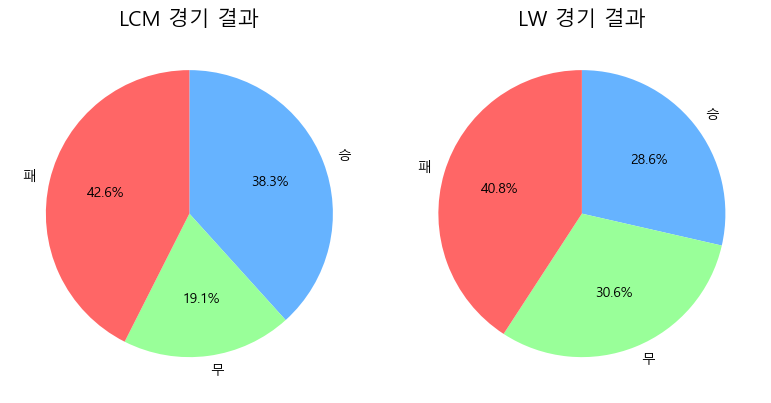

In [9]:
# 결과 카운트 계산 (승, 무, 패 순서대로)
lcm_result_counts = df[df['position']=='LCM']['matchResult'].value_counts()
lw_result_counts = df[df['position']=='LW']['matchResult'].value_counts()

# 승, 무, 패 순으로 값 정렬
match_result_order = ['승', '무', '패']

lcm_result_counts = lcm_result_counts.reindex(match_result_order, fill_value=0)
lw_result_counts = lw_result_counts.reindex(match_result_order, fill_value=0)

# Subplot 생성
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1행 2열로 subplot 배치

# lcm_result 파이차트
ax[0].pie(lcm_result_counts, labels=lcm_result_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'], counterclock=False)
ax[0].set_title('LCM 경기 결과', fontsize=15)

# lw_result 파이차트
ax[1].pie(lw_result_counts, labels=lw_result_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'], counterclock=False)
ax[1].set_title('LW 경기 결과', fontsize=15)

plt.tight_layout()
plt.show()

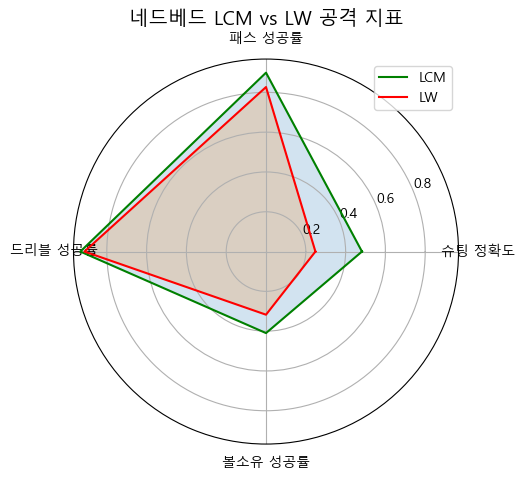

In [10]:
# 비교할 공격 지표 이름 설정
labels = ['슈팅 정확도', '패스 성공률', '드리블 성공률', '볼소유 성공률']

# 각 포지션별 지표 평균 계산 (LCM, LW)
lcm_id = [df[df['position']=='LCM']['shoot_ac'].mean(),
          df[df['position']=='LCM']['pass_sr'].mean(),
          df[df['position']=='LCM']['dribble_sr'].mean(),
          df[df['position']=='LCM']['ballPossesion_sr'].mean()]
lw_id = [df[df['position']=='LW']['shoot_ac'].mean(),
         df[df['position']=='LW']['pass_sr'].mean(),
         df[df['position']=='LW']['dribble_sr'].mean(),
         df[df['position']=='LW']['ballPossesion_sr'].mean()]

# 레이더 차트를 닫기 위해 시작 값을 마지막에 다시 추가
lcm_id.append(lcm_id[0])
lw_id.append(lw_id[0])

# 지표 수에 따라 각도를 균등 분할
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles.append(angles[0])    # 도형을 닫기 위해 첫 각도를 마지막에 추가

# 레이더 차트 생성 (polar = 극좌표계)
fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(5,5))

# LCM 꺾은선, 채우기
ax.plot(angles, lcm_id, label='LCM', color='green')
ax.fill(angles, lcm_id, alpha=0.2)
# LW 꺾은선, 채우기
ax.plot(angles, lw_id, label='LW', color='red')
ax.fill(angles, lw_id, alpha=0.2)

# 축에 지표 이름 표시 (도 단위로 변환 필요)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('네드베드 LCM vs LW 공격 지표', fontsize=14)
ax.legend(loc='upper right')
plt.show()

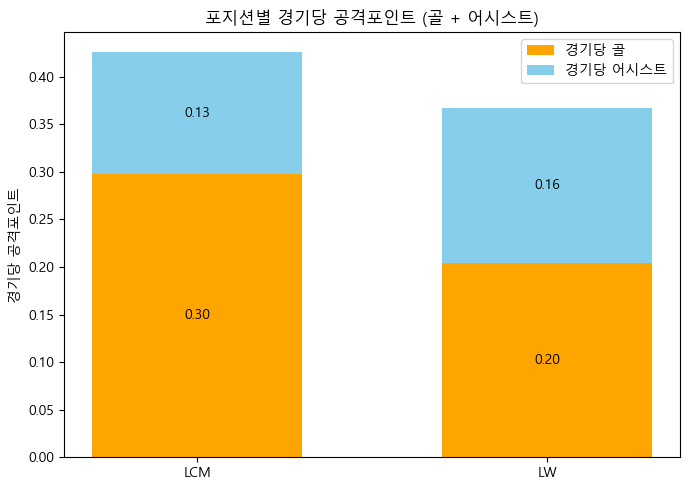

In [11]:
positions = ['LCM', 'LW']
goals_avg = [df[df['position']=='LCM']['goal'].mean(), df[df['position']=='LW']['goal'].mean()]
assists_avg = [df[df['position']=='LCM']['assist'].mean(), df[df['position']=='LW']['assist'].mean()]

x = np.arange(len(positions))
width = 0.6

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x, goals_avg, width, label='경기당 골', color='orange')
bars2 = ax.bar(x, assists_avg, width, bottom=goals_avg, label='경기당 어시스트', color='skyblue')

# 라벨 및 축 설정
ax.set_ylabel('경기당 공격포인트')
ax.set_title('포지션별 경기당 공격포인트 (골 + 어시스트)')
ax.set_xticks(x)
ax.set_xticklabels(positions)
ax.legend()

# 수치 라벨: 골과 어시스트 각각 표시
for i in range(len(x)):
    ax.text(x[i], goals_avg[i]/2, f"{goals_avg[i]:.2f}", ha='center', va='center', fontsize=10, color='black')
    ax.text(x[i], goals_avg[i] + assists_avg[i]/2, f"{assists_avg[i]:.2f}", ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### 4. A/B 테스트
- 네드베드 포지션 변경 영향 분석
- 경기 주요 지표 기반으로 성과 점수(performance_score) 생성
    - 성과 점수는 랜덤포레스트 변수 중요도 기반 가중 평균 방식으로 계산
- 검정 방법
    - Shapiro-Wilk 검정: 데이터 정규성 검정
    - Mann-Whitney U 검정: 두 집단의 순위 차이 비교
- 히스토그램 시각화

In [12]:
df_AB = df.copy()
df_AB['matchResult'] = df_AB['matchResult'].map({'승':0,'무':1,'패':2})

# 사용할 특성
features = ['matchResult', 'shoot_ac', 'assist', 'goal',
            'intercept', 'defending',
            'pass_sr', 'dribble_sr', 'ballPossesion_sr', 'aerial_sr',
            'block_sr', 'tackle_sr']

# 타겟은 성과의 대표지표인 'spRating' (변수 중요도 도출용)
X = df_AB[features]
y = df_AB['spRating']

# 표준화
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# 모델 학습
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# 변수 중요도 추출
importances = rf.feature_importances_

# 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df

,feature,importance
0,matchResult,0.084945
1,shoot_ac,0.019364
2,assist,0.145950
3,goal,0.489933
4,intercept,0.014977
5,defending,0.006399
6,pass_sr,0.067514
7,dribble_sr,0.043214
8,ballPossesion_sr,0.063235
9,aerial_sr,0.029592


In [13]:
# 가중치 딕셔너리로 변환
weights = importance_df.set_index('feature')['importance'].to_dict()

# 성과 점수 계산 (가중치 곱 후 합산)
df_AB['performance_score'] = X_scaled.apply(lambda row: sum(row[feature] * weights[feature] for feature in features), axis=1)

score_lcm = df_AB[df_AB['position'] == 'LCM']['performance_score']
score_lw = df_AB[df_AB['position'] == 'LW']['performance_score']

# 정규성 검정 (Shapiro-Wilk)
shapiro_p_lcm = shapiro(score_lcm).pvalue
shapiro_p_lw = shapiro(score_lw).pvalue

alpha = 0.05
print(f'shapiro_pvalue_lcm: {shapiro_p_lcm} → lcm_score는 정규성을 따르지 않습니다.') if shapiro_p_lcm < 0.05 else print(f'shapiro_pvalue_lcm: {shapiro_p_lcm}\nlcm_score는 정규성을 따릅니다.')
print(f'shapiro_pvalue_lw: {shapiro_p_lw} → lw_score는 정규성을 따르지 않습니다.') if shapiro_p_lw < 0.05 else print(f'shapiro_pvalue_lw: {shapiro_p_lw}\nlw_score는 정규성을 따릅니다.')

shapiro_pvalue_lcm: 1.2965695532329846e-05 → lcm_score는 정규성을 따르지 않습니다.
shapiro_pvalue_lw: 3.259453649206989e-07 → lw_score는 정규성을 따르지 않습니다.


In [14]:
# 비모수 검정 (Mann-Whitney U Test)
u_p = mannwhitneyu(score_lcm, score_lw, alternative='greater').pvalue

print(f"P-value: {u_p:.4f}")

P-value: 0.0061


✅ A/B 테스트 결론 요약
* 검정 방식: Mann–Whitney U Test (정규성 미충족으로 비모수 검정 사용)
* 귀무가설(H₀): 두 포지션의 성과 점수 분포에 차이가 없다 (혹은 LCM이 LW보다 크지 않다)
* 대립가설(H₁): LCM의 성과 점수가 LW보다 크다
* 검정 결과:
    * p-value = 0.0061 → 통계적으로 유의미한 차이 존재 (유의수준 0.05 기준) 
    * 즉, 귀무가설 기각 → LCM 포지션이 성과 점수에서 더 우수

🧾 결론 해석

>네드베드를 기존 LCM 포지션에서 LW 포지션으로 변경한 후의 데이터를 비교한 결과, LCM에서의 성과 점수가 통계적으로 유의하게 더 높음.
>따라서, 네드베드를 LCM에 배치하는 것이 성과 측면에서 더 유리하다고 판단 가능

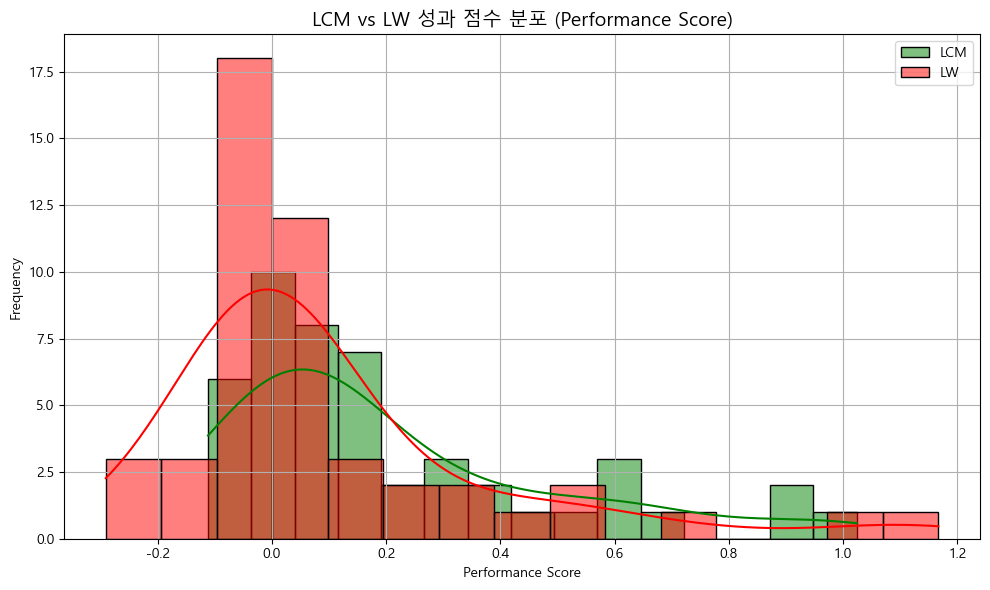

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(score_lcm, kde=True, color='green', label='LCM', bins=15)
sns.histplot(score_lw, kde=True, color='red', label='LW', bins=15)

plt.title('LCM vs LW 성과 점수 분포 (Performance Score)', fontsize=14)
plt.xlabel('Performance Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# 각 포지션별 왜도 및 첨도
dist_df = pd.DataFrame({
    '왜도 (Skewness)': [skew(score_lcm), skew(score_lw)],
    '첨도 (Kurtosis)': [kurtosis(score_lcm), kurtosis(score_lw)]
}, index=['LCM', 'LW'])

dist_df

,왜도 (Skewness),첨도 (Kurtosis)
LCM,1.319700,0.889431
LW,1.969718,3.901084


📐 왜도(Skewness)와 첨도(Kurtosis) 설명

✅ 왜도 (Skewness)
* 정의: 분포의 비대칭 정도를 나타냅니다.

* 해석:
    * 왜도 > 0 → 오른쪽으로 꼬리가 긴 우측 비대칭(Positive skew) → 값이 낮은 쪽에 몰려 있고 일부 큰 값들이 있음.
    * 왜도 < 0 → 왼쪽으로 꼬리가 긴 좌측 비대칭(Negative skew) → 값이 높은 쪽에 몰려 있고 일부 작은 값들이 있음.
    * 왜도 ≈ 0 → 거의 대칭 → 정규분포에 가까움.

✅ 첨도 (Kurtosis)
* 정의: 분포의 뾰족함 정도를 나타냅니다.

* 해석:
    * 첨도 > 3 → Leptokurtic (뾰족한 분포) → 극단값(꼬리 부분)이 더 많음 → 이상치 영향 큼.
    * 첨도 < 3 → Platykurtic (평평한 분포) → 평균 근처에 데이터가 덜 몰려 있고 분포가 퍼져 있음.
    * 첨도 ≈ 3 → Mesokurtic, 정규분포 수준의 뾰족함.

※ 보통 scipy.stats.kurtosis()는 Fisher 방식으로 정규분포의 첨도를 0으로 두므로:
* 0 → 정규
* \> 0 → 뾰족
* < 0 → 평평

🎯 LCM 포지션
* 왜도 (Skewness): 1.32
    * 우측으로 꼬리가 긴 비대칭 분포
    * 대부분의 경기에서 낮은 성과 점수를 기록했지만, 일부 경기에서 매우 높은 점수가 나온 경우가 있음
* 첨도 (Kurtosis): 0.89
    * 정규분포보다 살짝 더 뾰족한 분포 (Fisher 방식 기준, 0이 정규)
    * 극단값(이상치)이 약간 더 많이 존재하는 편이나, 그렇게 심하지는 않음

🎯 LW 포지션
* 왜도 (Skewness): 1.97
    * LCM보다 더 강한 우측 비대칭
    * 대부분 낮은 성과 점수를 기록했고, 일부 극히 적은 경기에서만 높은 점수가 나옴
* 첨도 (Kurtosis): 3.90
    * 매우 뾰족한 분포로, 극단값(이상치)이 많이 존재
    * 일부 극단적으로 높은 성과 경기들이 분포에 큰 영향을 주고 있음

🔍 요약 해석
* 두 포지션 모두 정규성을 만족하지 않음 (비대칭 + 꼬리가 긴 분포)
* LCM은 성과가 비교적 안정적이며, 일부 좋은 경기가 분포에 영향을 주는 정도
* LW는 대부분 부진한 경기이며, 몇몇 경기에서만 좋은 성과 → 불안정함이 크다는 특징
* 따라서 LCM이 더 일관되고 안정적인 포지션이라 평가 가능

이 결과는 비모수 검정을 사용한 A/B 테스트 결론(LW보다 LCM이 더 좋다)과도 잘 일치